In [3]:
import numpy as np
import torch
import torch.nn as nn
import gymnasium as gym
import random
import math
import matplotlib
from collections import namedtuple, deque
from itertools import count
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F

In [2]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 16.6 MB/s eta 0:00:00


In [4]:
env = gym.make("CartPole-v1")
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else"cpu")

In [5]:
Transition = namedtuple('Transition',('state','action','next_state','reward'))

In [6]:
class Replay_Memory(object):
    def __init__(self,capacity):
        self.memory = deque([],maxlen=capacity)
    def push(self,*args):
        self.memory.append(Transition(*args))
    def sample(self,batch_size):
        return random.sample(self.memory,batch_size)
    def __len__(self):
        return len(self.memory)

In [19]:
class dqn(nn.Module):

    def __init__(self,n_obs, n_act):
        super(dqn, self).__init__()
        self.l1 = nn.Linear(n_obs, 128)
        self.l2 = nn.Linear(128,128)
        self.l3 = nn.Linear(128, n_act)

    def forward(self,x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        return x

In [20]:
b_size= 128
gamma= 0.999
eps_start= 0.9
eps_end= 0.05
eps_decay= 1500
lr= 10e-3
TAU= 0.005
n_act= env.action_space.n

state, info = env.reset()
n_obs = len(state)

In [21]:
policy_net = dqn(n_obs, n_act).to(device)
target_net = dqn(n_obs, n_act).to(device)
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [22]:
optimizer= optim.Adam(policy_net.parameters(),lr=lr)
memory= Replay_Memory(10000)
steps_done = 0

def select_action(state):
  global steps_done
  sample= random.random()
  eps_threshold= eps_end + (eps_start - eps_end) * math.exp(-1. * steps_done / eps_decay)
  steps_done += 1
  if sample > eps_threshold:
      with torch.no_grad():

          return policy_net(state).max(1).indices.view(1, 1)
  else:
      return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())

    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [23]:
def optimize_model():
    if len(memory) < b_size:
        return
    transitions = memory.sample(b_size)

    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(b_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    criterion = nn.SmoothL1Loss() #huber loss
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


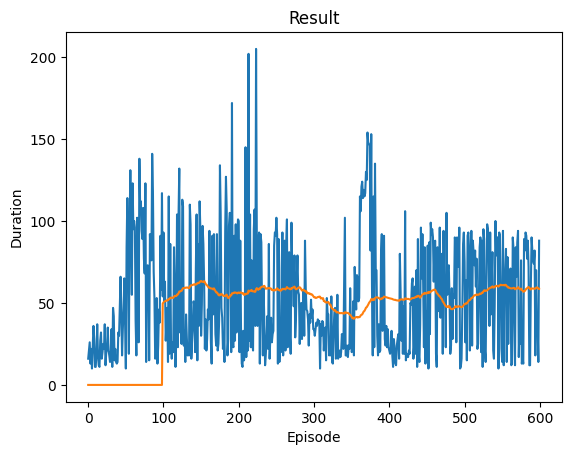

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [24]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)
        state = next_state
        optimize_model()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()